Algoritmo DQN

In [1]:
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import TanqueDisc
import random
import matplotlib.pyplot as plt

Clase DQN

In [2]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 32)
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, num_actions)

    def forward(self, states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.out(x)

Clase para el buffer de repetición

In [3]:
class ReplayBuffer(object):
    def __init__(self, size, device = 'cpu'):
        self.buffer = deque(maxlen = size)
        self.device = device

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, num_samples):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idx = np.random.choice(len(self.buffer), num_samples)
        for i in idx:
            elem = self.buffer[i]
            state, action, reward, next_state, done = elem
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        states = torch.as_tensor(np.array(states), device=self.device)
        actions = torch.as_tensor(np.array(actions), device=self.device)
        rewards = torch.as_tensor(np.array(rewards, dtype=np.float32), device=self.device)
        next_states = torch.as_tensor(np.array(next_states), device=self.device)
        dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
        return states, actions, rewards, next_states, dones

Toma de acción epsilon-greedy

In [4]:
def epsilon_greedy(state, epsilon, env, main_nn):
    result = np.random.uniform()
    if result < epsilon:
        return env.action_sample() # acción aleatoria
    else:
        qs = main_nn(state).cpu().data.numpy()
        return np.argmax(qs) # acción greedy

Función de entrenamiento para la red

In [5]:
def train_step(target_nn, discount, main_nn, optimizer, num_actions, loss_fn, states, actions, rewards, next_states, dones):
    max_next_qs = target_nn(next_states).max(-1).values
    target = rewards + (1.0 - dones) * discount * max_next_qs
    qs = main_nn(states)
    action_masks = F.one_hot(actions, num_actions)
    masked_qs = (action_masks * qs).sum(dim=-1)
    loss = loss_fn(masked_qs, target.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

Algoritmo q-learning (o DQN)

In [6]:
def qlearning():
    altura_objetivo = 1
    env = TanqueDisc.Tanque(altura_objetivo)
    num_features = 1 # solo hay una característica del ambiente: la altura
    num_actions = env.num_actions
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main_nn = DQN(num_features, num_actions).to(device)
    target_nn = DQN(num_features, num_actions).to(device)
    optimizer = torch.optim.Adam(main_nn.parameters(), lr = 1e-4)
    loss_fn = nn.MSELoss()
    #Hyperparámetros
    episodios = 1000
    eps1 = np.ones((episodios//2), dtype = np.float32)
    eps2 = np.linspace(1,0.01, num = episodios - (episodios//2)) # la épsilon va decrementando con el tiempo
    epsilon = np.concatenate([eps1, eps2])
    batch_size = 32
    discount = 0.99
    buffer = ReplayBuffer(100000, device = device)
    cur_frame = 0
    mean_reward = []
    for episode in range(episodios):
        hrand = random.random()*2 # el estado inicial será un número aleatorio entre 0 y 2
        env.h = hrand
        state = np.array([hrand], dtype=np.float32)
        ep_reward = 0
        done = False
        pasos_max = 1000
        pasos = 0
        while not done and pasos < pasos_max:
            state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
            action = epsilon_greedy(state_in, epsilon[episode], env, main_nn)
            next_state, reward, done = env.step(action)
            next_state = np.array([next_state]).astype(np.float32)
            ep_reward += reward
            # Se guarda la experiencia
            buffer.add(state, action, reward, next_state, done)
            state = next_state
            cur_frame += 1
            pasos += 1
            # copiar valores de main_nn a target_nn
            if cur_frame % 2000 == 0:
                target_nn.load_state_dict(main_nn.state_dict())
            # Entrenamiento
            if len(buffer) > batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                loss = train_step(target_nn, discount, main_nn, optimizer, num_actions, loss_fn, states, actions, rewards, next_states, dones)
        mean_reward.append(ep_reward/pasos)
    plt.plot([i for i in range(episodios)], mean_reward)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa promedio')
    plt.show()
    return(env, main_nn, device)

Algoritmo de control cuando la red ya está entrenada

In [14]:
def control(env, main_nn, device, h_inicial, max_pasos):
    tiempo = []
    alturas = []
    recompensas = []
    env.h = h_inicial
    state = env.h
    tiempo.append(0)
    alturas.append(env.h)
    done = False
    i = 1
    #while not done and i<max_pasos:
    while i<max_pasos:
        statenp = np.array([state], dtype = np.float32)
        state = torch.from_numpy(np.expand_dims(statenp, axis=0)).to(device)
        action = epsilon_greedy(state, 0.01, env, main_nn)
        state, reward, done = env.step(action)
        tiempo.append(i*env.ts)
        alturas.append(env.h)
        recompensas.append(reward)
        i += 1
    return (tiempo, alturas, recompensas)

Se prueba el algoritmo DQN y se grafica la recompensa media respecto al episodio.

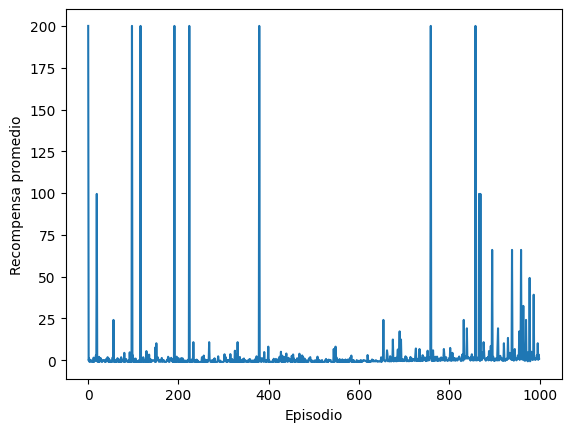

In [8]:
env, main_nn, device = qlearning()

Ahora se aplica el algoritmo de control y se grafica la altura del tanque respecto al tiempo. También se grafica la recompensa de esta política respecto al paso del episodio.

Primero se prueba el control cuando la altura inicial (0) está debajo de la altura objetivo (1).

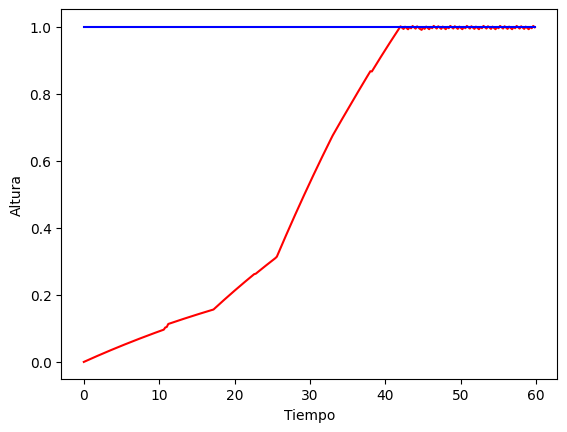

In [17]:
tiempo, alturas, recompensas = control(env, main_nn, device, 0, 300)
plt.plot(tiempo, alturas, 'r')
plt.plot(tiempo, [1.0 for i in range(len(tiempo))], 'b')
plt.xlabel('Tiempo')
plt.ylabel('Altura')
plt.show()

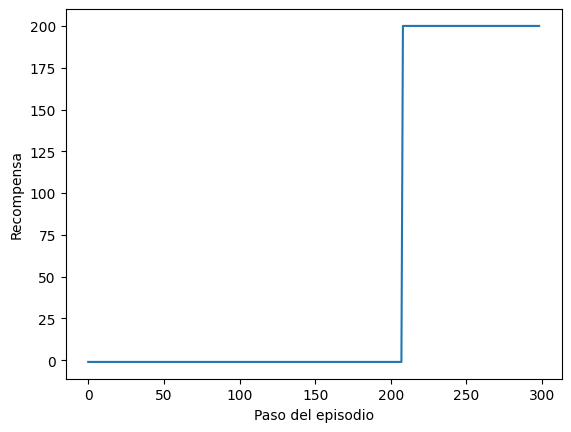

In [18]:
plt.plot([i for i in range(len(recompensas))], recompensas)
plt.xlabel('Paso del episodio')
plt.ylabel('Recompensa')
plt.show()

Ahora se probará cuando la altura inicial (1.7) está por arriba de la altura objetivo (1).

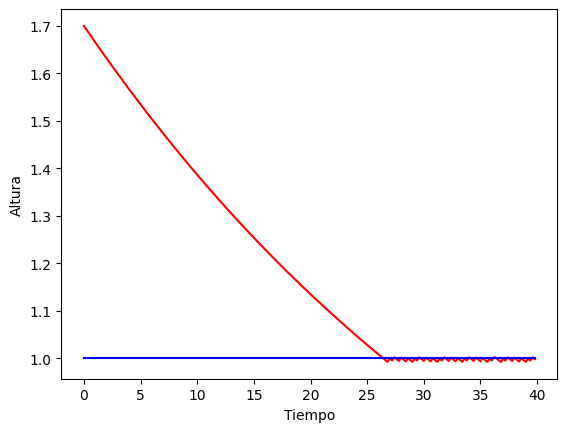

In [20]:
tiempo, alturas, recompensas = control(env, main_nn, device, 1.7, 200)
plt.plot(tiempo, alturas, 'r')
plt.plot(tiempo, [1.0 for i in range(len(tiempo))], 'b')
plt.xlabel('Tiempo')
plt.ylabel('Altura')
plt.show()

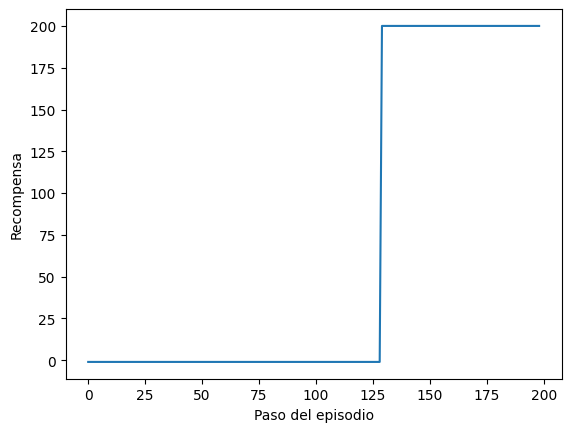

In [21]:
plt.plot([i for i in range(len(recompensas))], recompensas)
plt.xlabel('Paso del episodio')
plt.ylabel('Recompensa')
plt.show()